In [23]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage import measure, io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug
import visualization as viz
from training_utilities import TrainingMetrics, TrainingTimer
import glob
from astropy.io import fits
from random import randint
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_images_list = glob.glob('../Results/LWIRISEG/Results/*Train*.fits')
val_images_list = glob.glob('../Results/LWIRISEG/Results/*Val*.fits')
print(len(train_images_list))
print(len(val_images_list))
train_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in train_images_list]
val_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in val_images_list]

200
200


In [3]:
def binarize_image(img,pred):
    img_thresh = threshold_otsu(img)
    pred_thresh = threshold_otsu(pred)

    img_binary = img > img_thresh
    pred_binary = pred > pred_thresh

    return  img_binary, pred_binary

def count_blob(img):
    labels = measure.label(img, background=0)
    return labels.max()

def count_blobs(image_tuple):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    img_bin_count = count_blob(img_binary, background=0)
    pred_binary_count = count_blob(pred_binary, background=0)
    mask_count = count_blob(mask, background=0)
    #
    img_count = count_blob(img, background=0)
    pred_count = count_blob(pred, background=0)

    # The maximum label number is the count of blobs
    return f"Count : Image bin {img_bin_count}, Pred bin {pred_binary_count}, Mask {mask_count}, Image {img_count}, Pred {pred_count}" 

def compute_quality(binary_image):
    # Example metric: total area of clouds to the area of the sky
    img_bin_labels = measure.label(binary_image, background=0)
    regions = measure.regionprops(img_bin_labels)
    cloud_area = np.sum([region.area for region in regions])
    return cloud_area / binary_image.size

def quantify_sky_quality(image_tuple):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    sq_img_bin  = compute_quality(img_binary)
    sq_mask     = compute_quality(mask)
    sq_pred_bin = compute_quality(pred_binary)
    sq_img      = compute_quality(img)
    sq_pred     = compute_quality(pred)
    
    return f"SQ : Image bin {sq_img_bin}, Pred bin {sq_mask}, Mask {sq_pred_bin}, Image {sq_img}, Pred {sq_pred}" 



In [4]:
from utilities import *

In [5]:
otsu_preds = []
for i in range(0, len(val_fits)):
    raw_image = val_fits[i][0]
    t = threshold_otsu(raw_image)
    otsu_image = raw_image > t
    otsu_preds.append(otsu_image)

In [28]:
raw_image = val_fits[0][0]
raw_image2 = val_fits[100][0]

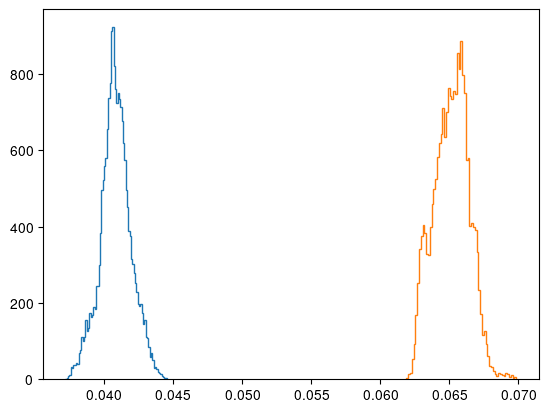

In [29]:
plt.figure()
plt.hist(raw_image.flatten()-np.mean(), bins='auto', histtype='step')
plt.hist(raw_image2.flatten(), bins='auto', histtype='step')
plt.show()

In [6]:
val_fits_np = np.array(val_fits)
flattened_arr = val_fits_np.reshape((200, 3, -1))

In [7]:
otsu_preds = np.array(otsu_preds)
flatten_otsu_preds = otsu_preds.reshape((200, -1)).astype(float)

In [8]:
"""
Evaluates the performance of a model using various metrics and saves the ROC data to a CSV file.

Args:
- y_true (array): Ground truth labels.
- y_pred_proba (array): Predicted probabilities.
- threshold (float): Threshold for classifying probabilities. Default is 0.5.
"""

def compute_metrics(y_true, y_pred_proba, threshold = 0.5):
    
    y_pred = (y_pred_proba > threshold).astype(int)
    y_true = (y_true > threshold).astype(int)

    # Flatten the arrays for pixel-wise operations
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()

    # Compute pixel-wise accuracy, precision, recall, and F1 score
    accuracy = np.mean(y_true_flat == y_pred_flat)
    precision = np.sum(y_true_flat * y_pred_flat) / (np.sum(y_pred_flat) + 1e-10)
    recall = np.sum(y_true_flat * y_pred_flat) / (np.sum(y_true_flat) + 1e-10)
    f1 = f1_score(y_true_flat, y_pred_flat)
    
    # Compute Error Rate (ER)
    TP = np.sum(y_true_flat * y_pred_flat)
    TN = np.sum((1 - y_true_flat) * (1 - y_pred_flat))
    FP = np.sum((1 - y_true_flat) * y_pred_flat)
    FN = np.sum(y_true_flat * (1 - y_pred_flat))
    ER = (FP + FN) / (TP + TN + FP + FN)
    
    bce = BinaryCrossentropy()
    loss = bce(y_true, y_pred_proba).numpy()
    
    # Compute the IOU metric (Intersection Over Union)
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    iou = intersection / (union + 1e-10)
    
    y_true_np = np.array(y_true.ravel())
    y_pred_proba_np = np.array(y_pred_proba.ravel())
    # Prepare the evaluation results text
    fpr, tpr, thresholds = roc_curve(y_true_np, y_pred_proba_np)
    auc_value = auc(fpr, tpr)
    
    results_text = (
        f"Mean Accuracy: {accuracy:.4f}\n"
        f"Mean Precision: {precision:.4f}\n"
        f"Mean Recall: {recall:.4f}\n"
        f"Mean F1 Score: {f1:.4f}\n"
        f"Error Rate (ER): {ER:.4f}\n"
        f"BinaryCrossEntropy Loss: {loss:.4f}\n"
        f"IOU: {iou:.4f}\n"
        f"Mean AUC: {auc_value:.4f}\n"
    )

    # Print the evaluation results
    print(results_text)

### Deep-learing segmentation model

In [9]:
compute_metrics(y_true=flattened_arr[:, 1, :], y_pred_proba=flattened_arr[:, 2, :], threshold = 0.5)

Mean Accuracy: 0.9517
Mean Precision: 0.9654
Mean Recall: 0.9789
Mean F1 Score: 0.9721
Error Rate (ER): 0.0483
BinaryCrossEntropy Loss: 0.1188
IOU: 0.9457
Mean AUC: 0.9816



### Otsu's algorithm

In [10]:
compute_metrics(y_true=flattened_arr[:, 1, :], y_pred_proba=flatten_otsu_preds, threshold = 0.5)

Mean Accuracy: 0.5916
Mean Precision: 1.0000
Mean Recall: 0.5253
Mean F1 Score: 0.6888
Error Rate (ER): 0.4084
BinaryCrossEntropy Loss: 6.2989
IOU: 0.5253
Mean AUC: 0.7627



In [11]:
# Reshape arr2 to (200, 1, 20480) to match the last dimension of arr1
arr2_reshaped = flatten_otsu_preds[:, np.newaxis, :]

# Concatenate along the second axis to get the desired shape
result = np.concatenate((flattened_arr, arr2_reshaped), axis=1)

In [12]:
#funct = count_blob
funct = quantify_sky_quality
indx = 0

Indx 40 counts SQ : Image bin 0.3818359375, Pred bin 0.543408203125, Mask 0.815478515625, Image 0.0, Pred 0.0
Indx 41 counts SQ : Image bin 0.3529296875, Pred bin 0.814599609375, Mask 0.79619140625, Image 0.0, Pred 0.01455078125
Indx 42 counts SQ : Image bin 0.47099609375, Pred bin 0.947900390625, Mask 0.952490234375, Image 0.0, Pred 0.0
Indx 43 counts SQ : Image bin 0.422265625, Pred bin 0.755029296875, Mask 0.729833984375, Image 0.0, Pred 0.003173828125
Indx 44 counts SQ : Image bin 0.476025390625, Pred bin 0.928515625, Mask 0.8275390625, Image 0.0, Pred 0.0


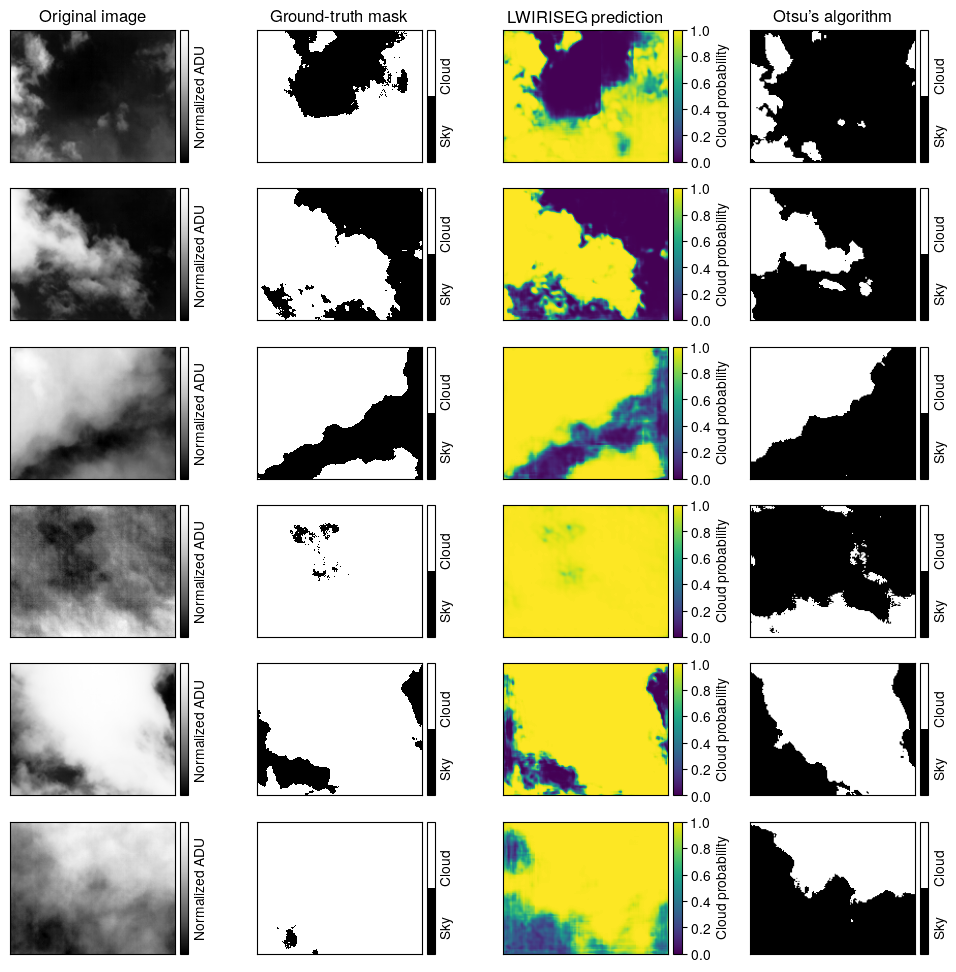

In [22]:
indx = indx + 1
nb = indx*5
print(f"Indx {nb-5} counts {funct(train_fits[nb-5])}")
print(f"Indx {nb-4} counts {funct(train_fits[nb-4])}")
print(f"Indx {nb-3} counts {funct(train_fits[nb-3])}")
print(f"Indx {nb-2} counts {funct(train_fits[nb-2])}")
print(f"Indx {nb-1} counts {funct(train_fits[nb-1])}")
viz.plot_image_preds2([result[101], result[189], result[18], result[1], result[161],result[5]],figsize_per_row=(12,12), output_path='../paper/figures/sample_prediction.pdf')
# '../paper/figures/sample_prediction.pdf'

In [14]:
# viz.plot_image_preds(train_fits[nb-5:nb],figsize_per_row=(16,14), output_path=None)